# Train EfficientNet on Fruits 360

We want to use the latest version of `torchvision`, Kaggle's current version of torchvision doesn't include EfficientNet, it was added in a later release

In [1]:
# !pip install -U torchvision
# !pip install timm

## Imports

Import all necesssary libraries for this project

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import warnings
warnings.filterwarnings('ignore')

In [4]:
torchvision.__version__, 
torch.__version__ 
# ('0.11.2+cu102', '1.10.1+cu102') or higher

'1.10.1+cu113'

In [5]:
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
from tqdm import tqdm
import time
import copy

## Dataset

In [7]:
# dataset_path = "/kaggle/input/fruits/fruits-360_dataset/fruits-360/"
# dataset_path = "../input/fruits-360-original-size/"
dataset_path = "../../Datasets/Covid-19-Image-Dataset-170MB/"

In [8]:
def get_data_loaders(data_dir, batch_size=64, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), 
                                                        transforms.GaussianBlur(3)]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.14, value='random')
        ])
        train_set = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)
        # train_set = datasets.ImageFolder(os.path.join(data_dir), transform=transform)
        
        
        print(f"Found {len(train_set)} images for training with {len(train_set.classes)} classes")
        train_data_len = int(len(train_set)*0.78)
        valid_data_len = int((len(train_set) - train_data_len))
        
        train_data, val_data = random_split(train_set, [train_data_len, valid_data_len])
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        
        return train_loader, val_loader, len(train_data), len(val_data)
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        print(f"Found {len(test_data)} images for testing with {len(test_data.classes)} classes")
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        return test_loader, len(test_data)

In [9]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [10]:
classes = get_classes(os.path.join(dataset_path, "train/"))
len(classes)

3

In [11]:
(train_loader, val_loader, train_data_len, valid_data_len) = get_data_loaders(dataset_path, 256, train=True)
(test_loader, test_data_len) = get_data_loaders(dataset_path, 64, train=False)

Found 251 images for training with 3 classes
Found 66 images for testing with 3 classes


In [12]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}

dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [13]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1
1
2


In [14]:
print(train_data_len, test_data_len, valid_data_len)
# print(train_data_len, valid_data_len)

195 66 56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

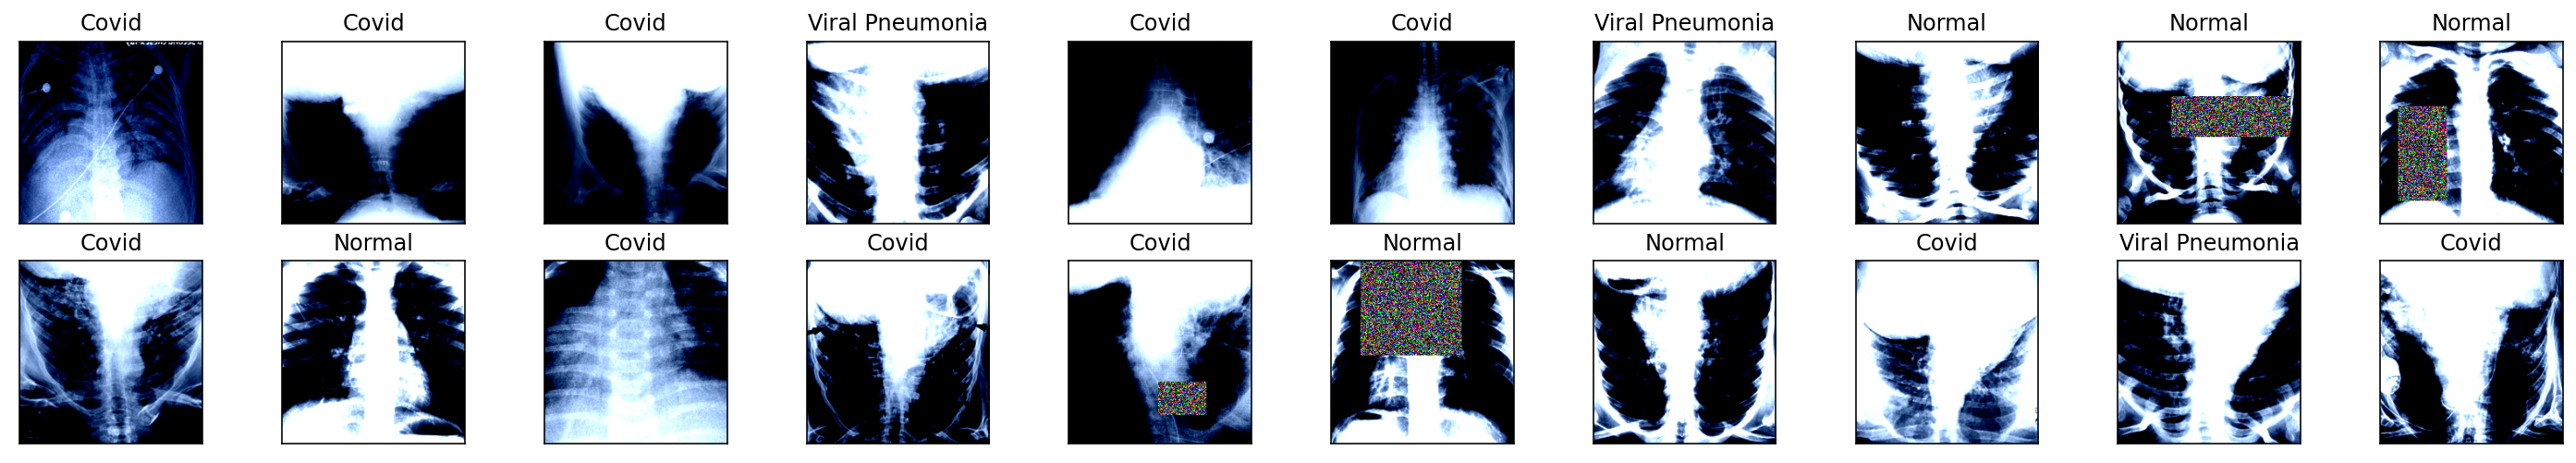

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Model

Load `efficientnet_b0` from torchvision Models

In [16]:
import timm
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
device

'cpu'

In [17]:
torch.backends.cudnn.benchmark = True # This will speed up training

model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=3, bias=True)
)


In [18]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

In [19]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [20]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

## Training

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    print('outputs on which to apply torch.max ', outputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------


100%|██████████| 1/1 [00:15<00:00, 15.74s/it]


outputs on which to apply torch.max  tensor([[ 2.0909, -0.5633, -1.2517],
        [ 0.8505, -0.2415, -0.4201],
        [ 0.8416, -0.2585, -0.4488],
        [ 1.8734, -0.4656, -1.1659],
        [ 1.0277,  0.0379, -1.0286],
        [ 0.8503, -0.2342, -0.5921],
        [ 0.0279, -0.0051, -0.0201],
        [ 1.4501, -0.4316, -0.7831],
        [ 0.8133, -0.1246, -0.6195],
        [ 1.3696,  0.0689, -1.3097],
        [ 2.0905, -0.1503, -1.8500],
        [ 0.8026,  0.5373, -1.3244],
        [ 0.9632, -0.3141, -0.4915],
        [ 0.5873,  0.4866, -0.8578],
        [ 0.1586, -0.0200,  0.0371],
        [ 0.7572,  0.5382, -1.1529],
        [ 1.4066, -0.4231, -0.7204],
        [ 1.6649, -0.6115, -0.8925],
        [ 0.5247,  0.4883, -0.9914],
        [ 0.5953,  0.3387, -0.7474],
        [ 0.9808, -0.3599, -0.7081],
        [ 1.0358, -0.2421, -0.8463],
        [ 0.6044, -0.1621, -0.3892],
        [ 0.3038,  0.3109, -0.6026],
        [ 0.8238,  0.2038, -0.9295],
        [ 0.8146, -0.1657, -0.4912],
 

100%|██████████| 1/1 [00:03<00:00,  3.87s/it]

outputs on which to apply torch.max  tensor([[-0.6386,  1.1677, -0.6023],
        [ 0.1401,  0.6236, -0.7587],
        [ 1.1683, -0.0278, -0.8989],
        [-1.1467,  1.7020, -0.6047],
        [-0.5480,  0.8131, -0.1884],
        [-0.2186,  0.5380, -0.2114],
        [ 0.4623,  0.0021, -0.4006],
        [-0.8547,  1.1798, -0.2932],
        [ 0.4617, -0.1354, -0.3650],
        [-0.7751,  1.3463, -0.5703],
        [-0.3314,  1.2209, -0.9267],
        [ 0.6170, -0.1142, -0.6006],
        [ 0.0287,  0.3088, -0.2566],
        [ 0.9435,  0.2952, -1.1725],
        [-0.5694,  0.4569,  0.1286],
        [-0.6131,  0.4730,  0.1579],
        [-0.8755,  1.1694, -0.1694],
        [-0.2141,  0.1763,  0.1404],
        [-0.4266,  0.4568,  0.0420],
        [ 0.6853, -0.1528, -0.5127],
        [ 0.3950,  0.2569, -0.7045],
        [-0.1969,  1.0801, -0.7528],
        [-0.0642,  0.9693, -0.8929],
        [-0.2428,  0.3696, -0.0940],
        [-0.5794,  0.9368, -0.3535],
        [ 0.4042,  0.1839, -0.5893],
 

## Evaluation

In [23]:
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()

  for data, target in tqdm(test_loader):
      # In local machine, gelow 2 Lines will NOT work if local GPU
      # itself or the GPU's Compute Capability is NOT compatible with PyTorch
      # if torch.cuda.is_available(): 
      #     data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [24]:
test(model_ft)

100%|██████████| 2/2 [00:03<00:00,  1.50s/it]

Test Loss: 1.048724

Test Accuracy of Covid: 64% (16/25)
Test Accuracy of Normal: 94% (18/19)
Test Accuracy of Viral Pneumonia:  0% ( 0/20)

Test Accuracy (Overall): 53.1250 (34.0/64.0)


## Save as torchscript model

In [25]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_ft.cpu(), example)
traced_script_module.save("fruits-360-efficientnet_b0.zip")